In [17]:
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import seaborn as sns

def plot_feature_improvement(df, old_feature, new_feature):
    pitting_df = df[df['is_pitting'] == True]
    not_pitting_df = df[df['is_pitting'] == False]

    fig = plt.figure(figsize=(15, 5), constrained_layout=True)

    gs = GridSpec(3, 7, figure=fig)
    ax1 = plt.subplot(gs.new_subplotspec((0, 0), colspan=3, rowspan=3))
    ax2 = plt.subplot(gs.new_subplotspec((0, 3), colspan=3, rowspan=3))
    ax3 = plt.subplot(gs.new_subplotspec((0, 6), colspan=1, rowspan=1))
    ax4 = plt.subplot(gs.new_subplotspec((1, 6), colspan=1, rowspan=1))
    ax5 = plt.subplot(gs.new_subplotspec((2, 6), colspan=1, rowspan=1))

    sns.kdeplot(pitting_df[new_feature], label='Pitting', ax=ax1)
    sns.kdeplot(not_pitting_df[new_feature], label='Not pitting', ax=ax1)
    ax1.grid()
    ax1.legend()
    ax1.set_title('Distribution of ' + new_feature)
    ax1.sharey(ax2)
    
    sns.kdeplot(pitting_df[old_feature], label='Pitting', ax=ax2)
    sns.kdeplot(not_pitting_df[old_feature], label='Not pitting', ax=ax2)
    ax2.grid()
    ax2.legend()
    ax2.set_title('Distribution of ' + old_feature)

    corr1 = df[[old_feature, new_feature, 'is_pitting']].corr('pearson')[['is_pitting']].sort_values(by='is_pitting', ascending=False)
    corr2 = df[[old_feature, new_feature, 'is_pitting']].corr('spearman')[['is_pitting']].sort_values(by='is_pitting', ascending=False)
    corr3 = df[[old_feature, new_feature, 'is_pitting']].corr('kendall')[['is_pitting']].sort_values(by='is_pitting', ascending=False)

    sns.heatmap(corr1.drop('is_pitting'), annot=True, fmt='.2f', cmap='coolwarm', ax=ax3, cbar=False)
    ax3.set_title('Pearson')

    sns.heatmap(corr2.drop('is_pitting'), annot=True, fmt='.2f', cmap='coolwarm', ax=ax4, cbar=False)
    ax4.set_title('Spearman')

    sns.heatmap(corr3.drop('is_pitting'), annot=True, fmt='.2f', cmap='coolwarm', ax=ax5, cbar=False)
    ax5.set_title('Kendall')

    plt.show()


from sklearn.preprocessing import StandardScaler

def scale_features(df, new_feature, old_feature):
    scaler = StandardScaler()
    scaler.fit(df[[old_feature, new_feature]])
    df[[old_feature, new_feature]] = scaler.transform(df[[old_feature, new_feature]])
    return df

## Add target ------------------------------------------------------------------

def process_target(df):
    df['is_pitting'] = df['PitStatus'] == 'InLap'
    df['is_pitting'] = df['is_pitting'].astype('bool')
    return df

In [5]:
from f1pitpred.loading import load_from_csv

data = load_from_csv(
    list(range(2021, 2023)),
)
from f1pitpred.preprocessing import *

In [18]:
preprocessed_data = preprocess_pre_split(data)
preprocessed_data = process_target(preprocessed_data)

In [20]:
df_hyp = preprocessed_data

df_hyp['LapTimeProportional'] = df_hyp['LapTime'] / df_hyp.groupby('Track')[['LapTime']].transform('median')['LapTime']

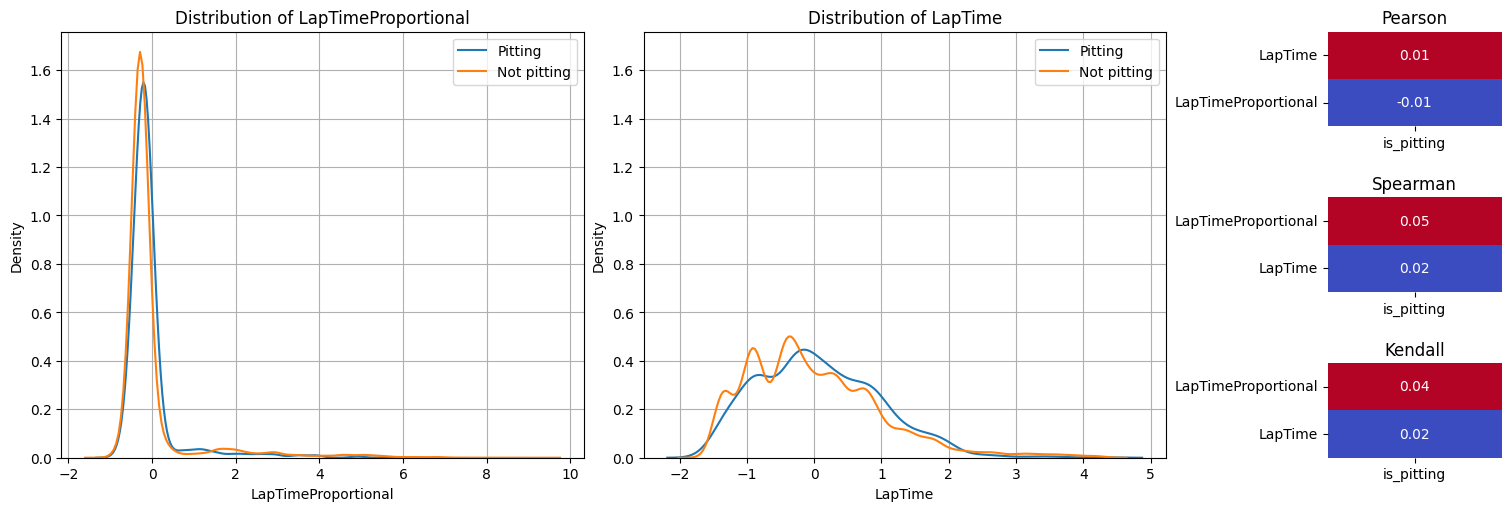

In [22]:
scale_features(df_hyp, 'LapTimeProportional', 'LapTime')
plot_feature_improvement(df_hyp, 'LapTime', 'LapTimeProportional')

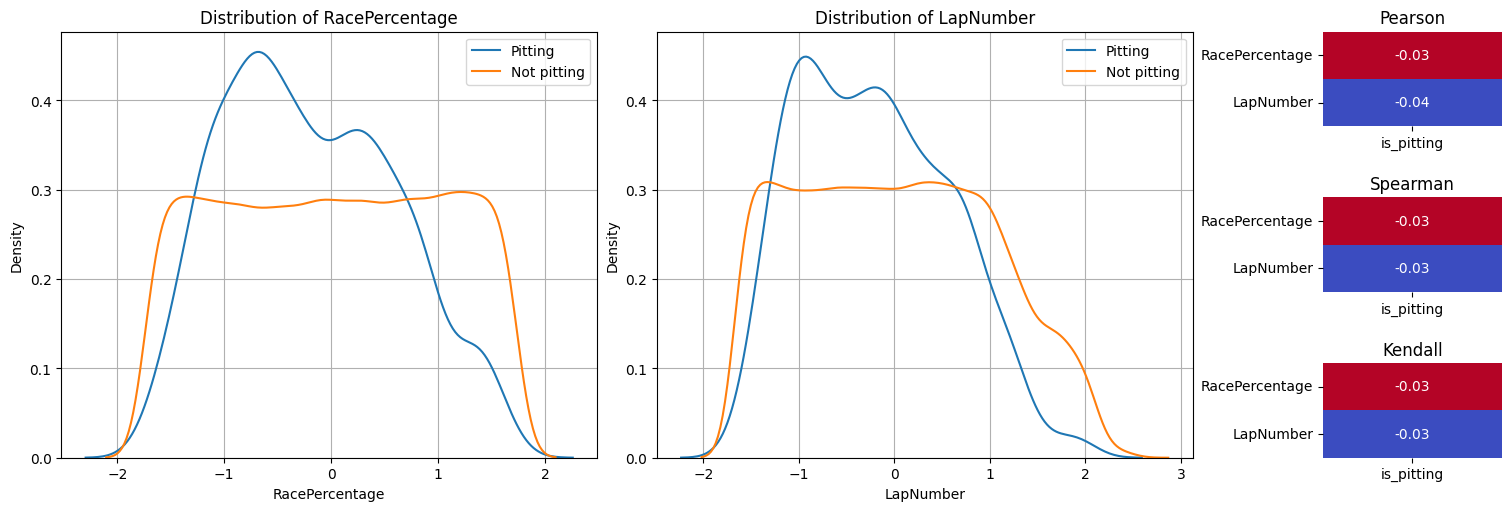

In [23]:
df_hyp['RacePercentage'] = df_hyp['LapNumber'] / df_hyp['TotalLaps']
scale_features(df_hyp, 'RacePercentage', 'LapNumber')
plot_feature_improvement(df_hyp, 'LapNumber', 'RacePercentage')

c:\Users\Nelson Jeanrenaud\miniconda3\envs\bsc\Lib\site-packages\seaborn\utils.py:80: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.draw()


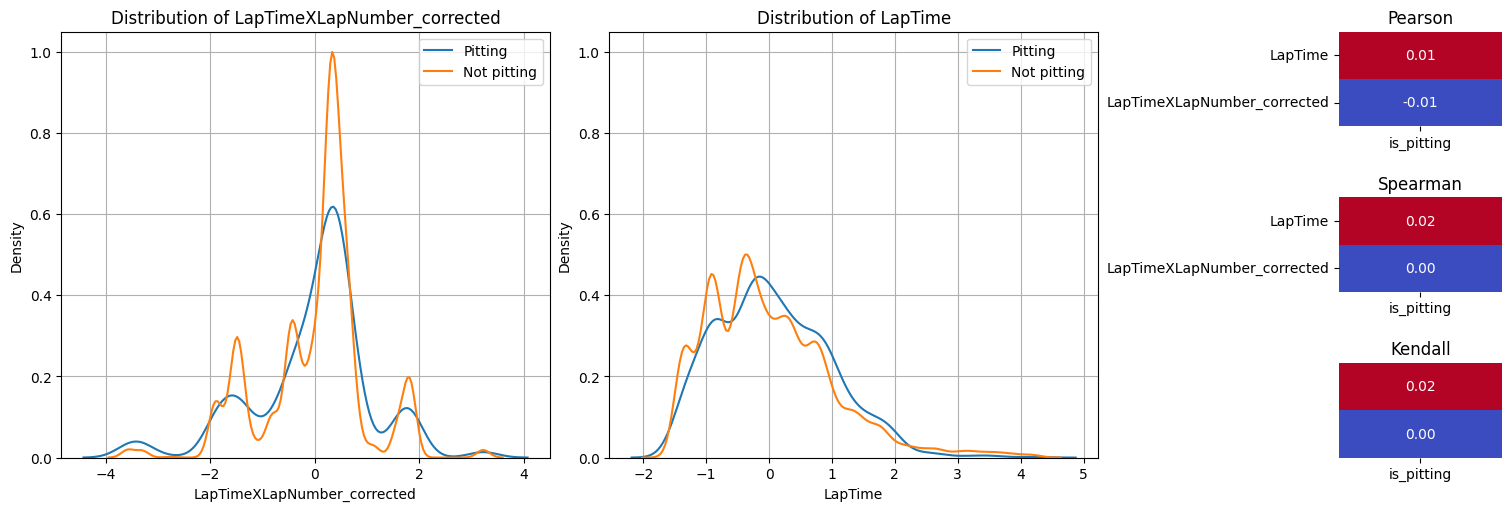

In [26]:
df_hyp['LapTimeXLapNumber'] = df_hyp['LapTime'] * df_hyp['LapNumber'] # TODO : find a better way to account for the fuel load
laptime_lapnb_corrected_per_track_per_compound = df_hyp.groupby(['Track', 'Compound'])['LapTimeXLapNumber'].median()
df_hyp = df_hyp.join(laptime_lapnb_corrected_per_track_per_compound, on=['Track', 'Compound'], rsuffix='_corrected')
scale_features(df_hyp, 'LapTime', 'LapTimeXLapNumber_corrected')
plot_feature_improvement(df_hyp, 'LapTime', 'LapTimeXLapNumber_corrected')